0. Checking data structure

How many folders, levels, files, etc.

In [1]:
from git import Repo

Repo.clone_from('https://github.com/glouppe/info8010-deep-learning/', 'C:/users/e.lavrova/desktop/courses/dl/')

<git.Repo "C:\users\e.lavrova\desktop\courses\dl\.git">

In [1]:
import os
import pandas as pd

root = '/Users/elizavetalavrova/Desktop/NSCLC-Radiomics'

#root = '"""SOME DIR"""/NSCLC-Radiomics'

DB = []
for name in os.listdir(root):
    fullname = os.path.join(root,name)
    if os.path.isdir(fullname):
        R = {
        'PatientID': '', #patient name
        'noc1': '', #N of content components in patient folder - not needed
        'nod1': '', #N of directory components in patient folder - not needed
        'noc2': '', #N of content components in study folder (should be 1) - not needed
        'nod2': '', #N of directory components in study folder (should be 1) - not needed
        'nodid2': '', #N of directory components with images in study folder (should be 1) - not needed
        'noi': '', #N of images - not needed
        'loi': [], #patient images full names 
        'loc': [] #patient RT file full name
        }
        R['PatientID'] = name
        R['noc1'] = len(os.listdir(fullname))
        R['nod1'] = len([name1 for name1 in os.listdir(fullname) if os.path.isdir(os.path.join(fullname, name1))])
        for name1 in os.listdir(fullname):
            fullname1 = os.path.join(fullname,name1)
            if os.path.isdir(fullname1):
                R['noc2'] = len(os.listdir(fullname1)) 
                R['nod2'] = len([name2 for name2 in os.listdir(fullname1) if os.path.isdir(os.path.join(fullname1, name2))])                 
                did2 = 0
                for name2 in os.listdir(fullname1):
                    fullname2 = os.path.join(fullname1,name2)      
                    if os.path.isdir(fullname2):
                        nofiles = len([name3 for name3 in os.listdir(fullname2) if (os.path.isfile(os.path.join(fullname2, name3)) and not name3.startswith('.'))])
                        if nofiles > 1:
                            did2 = did2 + 1
                            R['noi'] = nofiles
                            imlist = [os.path.join(fullname2, name3) for name3 in os.listdir(fullname2) if (os.path.isfile(os.path.join(fullname2, name3)) and not name3.startswith('.'))]
                            imlist.sort()
                            R['loi'] = imlist
                        if nofiles ==1:
                            R['loc'] = [os.path.join(fullname2, name3) for name3 in os.listdir(fullname2) if (os.path.isfile(os.path.join(fullname2, name3)) and not name3.startswith('.'))]
                R['nodid2'] = did2
        DB.append(R)
            
import operator
DB.sort(key=operator.itemgetter('PatientID'))

db = pd.DataFrame(DB, columns=['PatientID','noc1','nod1','noc2','nod2','nodid2','noi','loi','loc'])


In [2]:
# checking absence of RT data

for i in range (0, len(db)):    
    db.loc[i,'RT_miss'] = not(len(db['loc'][i]) > 0)

1. Survival Analysis

Clinical data acquisition and analysis

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage import data, io, filters
from skimage.transform import resize
import scipy as sp

df = pd.read_csv('Lung1.clinical.csv')
df.columns = ['PatientID', 'age', 'Clinical_T_Stage', 'Clinical_N_Stage', 'Clinical_M_Stage', 'Overall_Stage', 'Histology', 'gender', 'Survival_time', 'deadstatus_event']

df

,PatientID,age,Clinical_T_Stage,Clinical_N_Stage,Clinical_M_Stage,Overall_Stage,Histology,gender,Survival_time,deadstatus_event
0,LUNG1-001,78.7515,2,3,0,IIIb,large cell,male,2165,1
1,LUNG1-002,83.8001,2,0,0,I,squamous cell carcinoma,male,155,1
2,LUNG1-003,68.1807,2,3,0,IIIb,large cell,male,256,1
3,LUNG1-004,70.8802,2,1,0,II,squamous cell carcinoma,male,141,1
4,LUNG1-005,80.4819,4,2,0,IIIb,squamous cell carcinoma,male,353,1
5,LUNG1-006,73.8864,3,1,0,IIIa,squamous cell carcinoma,male,173,1
6,LUNG1-007,81.5288,2,2,0,IIIa,squamous cell carcinoma,male,137,1
7,LUNG1-008,71.6660,2,2,0,IIIa,adenocarcinoma,male,77,1
8,LUNG1-009,56.1342,2,2,0,IIIa,squamous cell carcinoma,male,131,1
9,LUNG1-010,71.0554,4,3,0,IIIb,squamous cell carcinoma,female,2119,0


In [4]:
#checking contents of cat data columns

print(df['Overall_Stage'].value_counts()) 
print()
print(df['Histology'].value_counts())
print()
print(df['Clinical_T_Stage'].value_counts()) 
print()
print(df['Clinical_N_Stage'].value_counts()) 
print()
print(df['Clinical_M_Stage'].value_counts()) 
print()

IIIb    176
IIIa    112
I        93
II       40
Name: Overall_Stage, dtype: int64

squamous cell carcinoma    152
large cell                 114
nos                         63
adenocarcinoma              51
Name: Histology, dtype: int64

2    156
4    117
1     93
3     53
5      2
Name: Clinical_T_Stage, dtype: int64

0    170
2    141
3     85
1     23
4      3
Name: Clinical_N_Stage, dtype: int64

0    417
3      4
1      1
Name: Clinical_M_Stage, dtype: int64



2y survived:  96.0 , 2y died:  214.0 , 2y survival rate:  0.3096774193548387


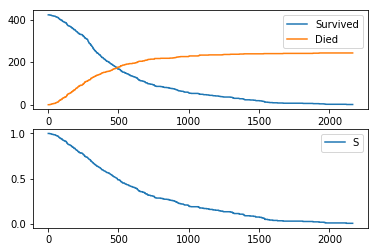

In [9]:
st = df['Survival_time'][:]
ds = df['deadstatus_event'][:]
time_period = max(st)

N_s = np.zeros(time_period)
N_d = np.zeros(time_period)
SR = np.zeros(time_period)
for i in range (1, time_period+1):
    N_s[i-1] = sum(df['Survival_time'][:] >= i)
    N_d[i-1] = sum((df['Survival_time'][:] < i) & (df['deadstatus_event'][:] == 1))
    SR[i-1] = N_s[i-1]/(N_s[i-1]+N_d[i-1])
    
t = np.arange(1, time_period+1, 1)
plt.subplot(211)
plt.plot(t, N_s, t, N_d)
plt.legend(('Survived', 'Died'))
plt.subplot(212)
plt.plot(t, SR)
plt.legend(('Survival Rate'))
print('2y survived: ', N_s[730], ', 2y died: ', N_d[730], ', 2y survival rate: ', SR[730])

([array([ 1., 67., 37., 21., 14., 10., 16.,  8.,  1.,  3.]),
  array([90., 69., 45., 15., 14.,  4.,  2.,  2.,  2.,  1.])],
 array([  10. ,  225.5,  441. ,  656.5,  872. , 1087.5, 1303. , 1518.5,
        1734. , 1949.5, 2165. ]),
 <a list of 2 Lists of Patches objects>)

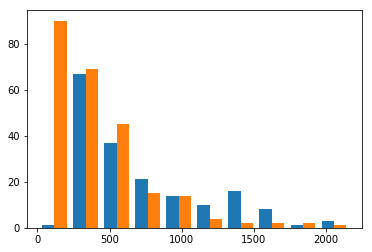

In [10]:
#checking distribution in time (almost similiar)

S = df[['Survival_time' ,'deadstatus_event']][:]

Class1 = S[S['deadstatus_event']==0]
Class2 = S[S['deadstatus_event']==1]

plt.hist([Class1['Survival_time'], Class2['Survival_time']])

In [11]:
s2 = (df['Survival_time']>=730).astype(int)
s2 = s2.mask((df['Survival_time']<730)&(df['deadstatus_event']==0))
df['s2'] = s2.values

# not start this step after following NA dropping

2. Clinical data based ML

NN for 2 y. survival estimation with clinical data as an input

In [13]:
from sklearn.model_selection import train_test_split
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

df = df.dropna(subset=['s2'])

train, test = train_test_split(df, test_size=0.33)
test.loc[:,'Type'] = 'Train' 
test.loc[:,'Type'] = 'Test'
ds = pd.concat([train,test],axis=0)

In [14]:
ID_col = ['PatientID']
flag_col= ['Type']
target_col = ['s2']
cat_cols= ['Clinical_T_Stage','Clinical_N_Stage','Clinical_M_Stage','Overall_Stage','Histology', 'gender']
num_cols= ['age', 'Survival_time']
num_cat_cols = num_cols+cat_cols

In [15]:
# Create a new variable for each variable having missing value with VariableName_NA 
# And flag missing value with 1 and other with 0
for var in num_cat_cols:
    if ds[var].isnull().any()==True:
        ds[var+'_NA']=ds[var].isnull()*1
# Impute numerical missing values with mean
ds[num_cols] = ds[num_cols].fillna(ds[num_cols].mean())
# Impute categorical missing values with -9999
ds[cat_cols] = ds[cat_cols].fillna(value = -9999)

In [16]:
# create label encoders for categorical features
from sklearn.preprocessing import LabelEncoder
for var in cat_cols:
    number = LabelEncoder()
    ds[var] = number.fit_transform(ds[var].astype('str'))
for var in flag_col:
    number = LabelEncoder()
    ds[var] = number.fit_transform(ds[var].astype('str'))

In [17]:
features = list(set(list(ds.columns))-set(ID_col)-set(target_col)-set('deadstatus_event'))
ds[features] = ds[features]/ds[features].max()

In [18]:
# Creating a validation set
train=ds[ds['Type']==1]
test=ds[ds['Type']==0]
features=list(cat_cols+num_cols)
X = train[features].values
y = train[target_col].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=seed)

In [20]:
# MLP 
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
import numpy

# create model
model = Sequential()
model.add(Dense(24, input_dim=8, activation='sigmoid'))
model.add(Dense(24, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.summary() #Print model Summary

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 24)                216       
_________________________________________________________________
dense_5 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 25        
Total params: 841
Trainable params: 841
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
# Fit the model
y_score = model.fit(X_train, y_train, validation_data=(X_valid,y_valid), epochs=75, batch_size=10, shuffle = True)

Train on 138 samples, validate on 69 samples
Epoch 1/75
138/138 [==============================] - 0s 3ms/step - loss: 0.5516 - binary_accuracy: 0.6739 - val_loss: 0.5546 - val_binary_accuracy: 0.6667
Epoch 2/75
138/138 [==============================] - 0s 213us/step - loss: 0.5466 - binary_accuracy: 0.6739 - val_loss: 0.5510 - val_binary_accuracy: 0.6812
Epoch 3/75
138/138 [==============================] - 0s 261us/step - loss: 0.5430 - binary_accuracy: 0.6739 - val_loss: 0.5476 - val_binary_accuracy: 0.6812
Epoch 4/75
138/138 [==============================] - 0s 254us/step - loss: 0.5394 - binary_accuracy: 0.6739 - val_loss: 0.5438 - val_binary_accuracy: 0.6812
Epoch 5/75
138/138 [==============================] - 0s 257us/step - loss: 0.5357 - binary_accuracy: 0.6739 - val_loss: 0.5403 - val_binary_accuracy: 0.6812
Epoch 6/75
138/138 [==============================] - 0s 249us/step - loss: 0.5332 - binary_accuracy: 0.6739 - val_loss: 0.5360 - val_binary_accuracy: 0.7101
Epoch 7/7

0.9792060491493384


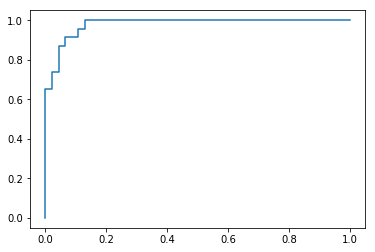

In [23]:
from sklearn import *
pred= model.predict(X_valid)
#pred = np.around(pred)

#ROC (Receiver Operating Characteristic) - FPR/FRR - DONE
fpr, tpr, thresholds = metrics.roc_curve(y_valid, pred)
plt.plot(fpr, tpr)

#AUC (Area Under Curve) - Area Under ROC Curve - should be with confidence intervals
print(metrics.roc_auc_score(y_valid, pred))

In [24]:
# Confusion matrix - True: Positive, Negative (Classified: Positive, Negative) - DONE
CM = metrics.confusion_matrix(y_valid, np.around(pred))
print(CM)

[[45  1]
 [ 6 17]]


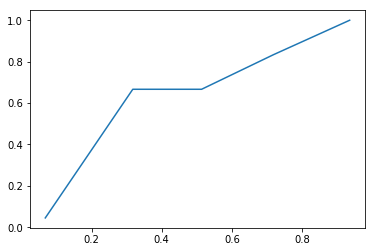

In [25]:
#Calibration curve - True Probability in each bin (Predicted Probability) - DONE
tpr, ppr = calibration.calibration_curve(y_valid, pred)
plt.plot(ppr, tpr)

In [ ]:
# check one more time as the results sometimes are not really good (sometimes too many mistakes and sometines overfitting?)

3. Adding DICOM data to dataset

In [26]:
# checking presence of RT data

d = pd.merge(db, df, on='PatientID')
d[d['s2'].isnull()|d['RT_miss']==True]

,PatientID,noc1,nod1,noc2,nod2,nodid2,noi,loi,loc,RT_miss,age,Clinical_T_Stage,Clinical_N_Stage,Clinical_M_Stage,Overall_Stage,Histology,gender,Survival_time,deadstatus_event,s2
6,LUNG1-007,2,1,2,1,1,129,[/Users/elizavetalavrova/Desktop/NSCLC-Radiomi...,[],True,81.5288,2,2,0,IIIa,squamous cell carcinoma,male,137,1,0
33,LUNG1-036,1,1,1,1,1,135,[/Users/elizavetalavrova/Desktop/NSCLC-Radiomi...,[],True,54.0068,2,2,0,IIIa,large cell,female,366,1,0
47,LUNG1-050,1,1,1,1,1,104,[/Users/elizavetalavrova/Desktop/NSCLC-Radiomi...,[],True,53.5743,2,2,0,IIIa,squamous cell carcinoma,male,208,1,0
55,LUNG1-058,1,1,1,1,1,297,[/Users/elizavetalavrova/Desktop/NSCLC-Radiomi...,[],True,82.2779,2,0,0,I,large cell,male,673,1,0
64,LUNG1-067,1,1,1,1,1,176,[/Users/elizavetalavrova/Desktop/NSCLC-Radiomi...,[],True,75.9671,1,2,0,IIIa,nos,male,1596,0,1
195,LUNG1-200,1,1,1,1,1,134,[/Users/elizavetalavrova/Desktop/NSCLC-Radiomi...,[],True,66.8337,3,0,0,II,adenocarcinoma,male,468,1,0
197,LUNG1-202,1,1,1,1,1,134,[/Users/elizavetalavrova/Desktop/NSCLC-Radiomi...,[],True,69.6740,3,1,0,IIIa,squamous cell carcinoma,male,82,1,0
264,LUNG1-301,1,1,1,1,1,119,[/Users/elizavetalavrova/Desktop/NSCLC-Radiomi...,[],True,81.9192,2,2,0,IIIa,large cell,male,217,1,0
272,LUNG1-312,1,1,1,1,1,134,[/Users/elizavetalavrova/Desktop/NSCLC-Radiomi...,[],True,65.5058,2,2,0,IIIa,squamous cell carcinoma,female,392,1,0
278,LUNG1-327,1,1,1,1,1,131,[/Users/elizavetalavrova/Desktop/NSCLC-Radiomi...,[],True,54.7351,4,0,0,IIIb,large cell,male,261,1,0


In [27]:
# adding data about number of ROI and GTV 

import pydicom
for i in range (0, len(d)):
    if len(d['loc'][i])>0:
        dcm_RT = pydicom.dcmread(d['loc'][i][0])
        d.loc[i, 'n_contours'] = len(dcm_RT.StructureSetROISequence)
        if len(dcm_RT.StructureSetROISequence)>0:
            d.loc[i,'GTV'] = dcm_RT.StructureSetROISequence[0].ROIVolume
        

In [28]:
# checking if during every study there was explored not more than 1 ROI

print(d['n_contours'].value_counts()) 
print()
# all RT struct files contain 1 contour (except 176th), NaN values correspond to RT_miss

1    274
0      1
Name: n_contours, dtype: int64



4. Getting familiar with DICOM structure

With '000001.dcm' as an image and '000000.dcm' as an RT structure

In [29]:
import pydicom
import matplotlib.pyplot as plt
import math
import numpy as np

In [30]:
dcm_img = pydicom.dcmread('000001.dcm') 
dcm_img

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.32722.99.99.21419423495670765708010380961504124946
(0008, 0020) Study Date                          DA: '20080918'
(0008, 0021) Series Date                         DA: '20080918'
(0008, 0022) Acquisition Date                    DA: '20080918'
(0008, 0023) Content Date                        DA: '20080918'
(0008, 0030) Study Time                          TM: '110915.625000'
(0008, 0031) Series Time                         TM: '121748.328000'
(0008, 0032) Acquisition Time                    TM: '113840.421787'
(0008, 0033) Content Time                        TM: '113840.421787'
(0008, 0050) Accession Number                    SH: '2819497684894126'
(0008, 0060) Modality                      

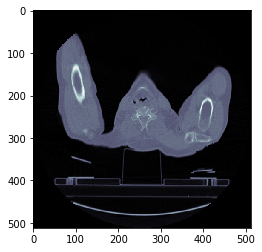

In [31]:
plt.imshow(dcm_img.pixel_array, cmap=plt.cm.bone)

In [32]:
dcm_RT = pydicom.dcmread('000000.dcm')
ctrs = dcm_RT.ROIContourSequence

In [33]:
ctrs[0] #first contour (and should be the one)

(3006, 002a) ROI Display Color                   IS: ['64', '64', '255']
(3006, 0040)  Contour Sequence   21 item(s) ---- 
   (3006, 0016)  Contour Image Sequence   1 item(s) ---- 
      (0008, 1150) Referenced SOP Class UID            UI: CT Image Storage
      (0008, 1155) Referenced SOP Instance UID         UI: 1.3.6.1.4.1.32722.99.99.127986385990000539727681971184371746831
      ---------
   (3006, 0042) Contour Geometric Type              CS: 'CLOSED_PLANAR'
   (3006, 0046) Number of Contour Points            IS: "60"
   (3006, 0048) Contour Number                      IS: "1"
   (3006, 0050) Contour Data                        DS: ['78', '-217.2', '-486.5', '78', '-217.9', '-486.5', '77.3', '-217.9', '-486.5', '76.6', '-217.9', '-486.5', '75.9', '-217.9', '-486.5', '75.2', '-217.9', '-486.5', '74.5', '-217.9', '-486.5', '74.5', '-217.2', '-486.5', '73.8', '-217.2', '-486.5', '73.1', '-217.2', '-486.5', '73.1', '-216.5', '-486.5', '72.4', '-216.5', '-486.5', '71.7', '-216.5', '-48

In [34]:
ctrs[0].ContourSequence[0].ContourData #first contour on first slice

['78', '-217.2', '-486.5', '78', '-217.9', '-486.5', '77.3', '-217.9', '-486.5', '76.6', '-217.9', '-486.5', '75.9', '-217.9', '-486.5', '75.2', '-217.9', '-486.5', '74.5', '-217.9', '-486.5', '74.5', '-217.2', '-486.5', '73.8', '-217.2', '-486.5', '73.1', '-217.2', '-486.5', '73.1', '-216.5', '-486.5', '72.4', '-216.5', '-486.5', '71.7', '-216.5', '-486.5', '71.7', '-215.8', '-486.5', '71', '-215.8', '-486.5', '71', '-215.1', '-486.5', '70.3', '-215.1', '-486.5', '70.3', '-214.4', '-486.5', '69.6', '-214.4', '-486.5', '69.6', '-213.7', '-486.5', '68.9', '-213.7', '-486.5', '68.9', '-213', '-486.5', '68.9', '-212.3', '-486.5', '68.2', '-212.3', '-486.5', '68.2', '-211.5', '-486.5', '68.2', '-210.8', '-486.5', '67.5', '-210.8', '-486.5', '67.5', '-210.1', '-486.5', '67.5', '-209.4', '-486.5', '67.5', '-208.7', '-486.5', '67.5', '-208', '-486.5', '67.5', '-207.3', '-486.5', '68.2', '-206.6', '-486.5', '68.9', '-206.6', '-486.5', '69.6', '-206.6', '-486.5', '70.3', '-206.6', '-486.5', '71

In [35]:
dcm_RT.StructureSetROISequence[0] # ROI info

(3006, 0022) ROI Number                          IS: "2"
(3006, 0024) Referenced Frame of Reference UID   UI: 1.3.6.1.4.1.32722.99.99.159382531350253250387871175467326315430
(3006, 0026) ROI Name                            LO: 'GTV-1'
(3006, 0028) ROI Description                     ST: 'GTV-1'
(3006, 002c) ROI Volume                          DS: "155.9"
(3006, 0036) ROI Generation Algorithm            CS: 'MANUAL'

In [36]:
dcm_RT.StructureSetROISequence[0].ROIVolume # how to acquire particular info

"155.9"

In [37]:
# reading coordinates of all the points

X = []
Y = []
Z = []

n = np.array([])

for i in range (0, len(ctrs[0].ContourSequence)):
    x = np.array([])
    y = np.array([])
    z = np.array([])
    n = np.append(n, len(ctrs[0].ContourSequence[i].ContourData)/3)
    
    for j in range (0, int(len(ctrs[0].ContourSequence[i].ContourData)/3)):
        x = np.append(x, ctrs[0].ContourSequence[i].ContourData[3*j])
        y = np.append(y, ctrs[0].ContourSequence[i].ContourData[3*j+1])
        z = np.append(z, ctrs[0].ContourSequence[i].ContourData[3*j+2])
    X.append(x)
    Y.append(y)
    Z.append(z)
    
flat_X = [item for sublist in X for item in sublist]
flat_Y = [item for sublist in Y for item in sublist]
flat_Z = [item for sublist in Z for item in sublist]

len(X), len(Y), len(Z), len(n)

(21, 21, 21, 21)

Text(0.5, 0, 'Z')

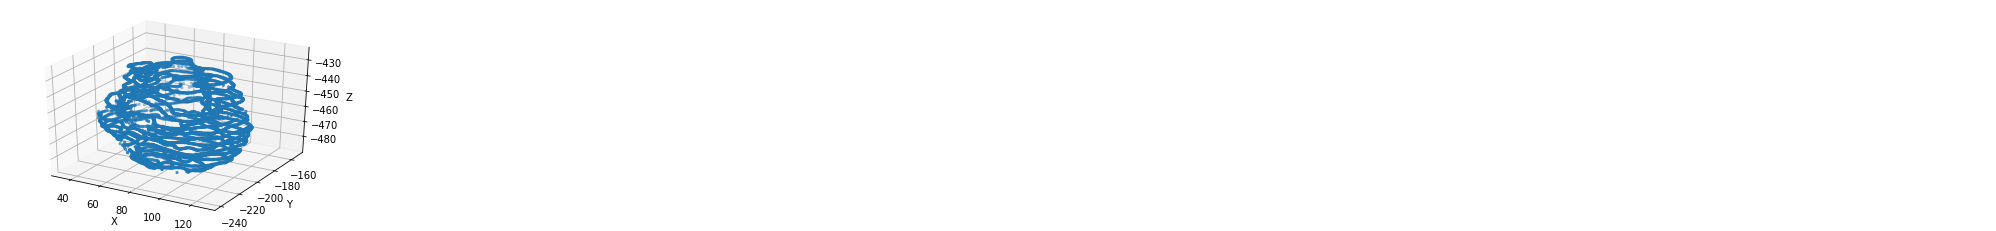

In [38]:
# ROI volume visualization

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(flat_X, flat_Y, flat_Z, marker = '.')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

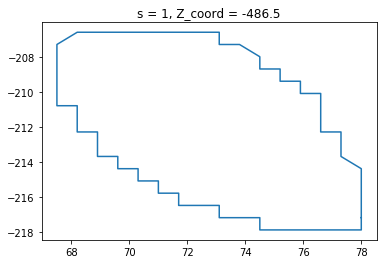

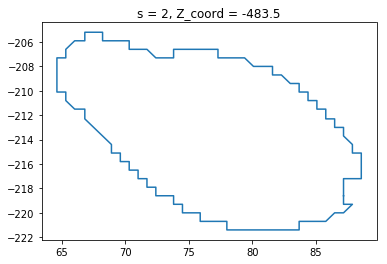

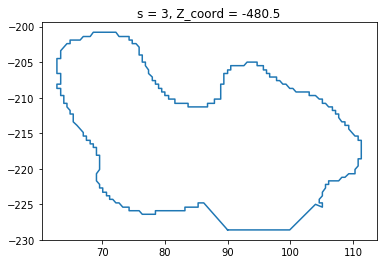

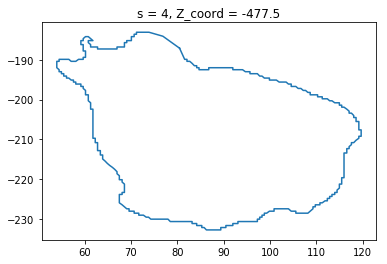

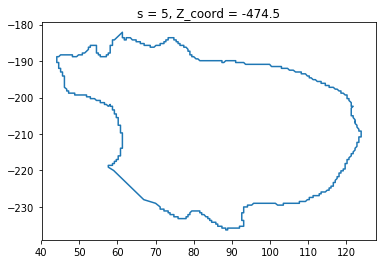

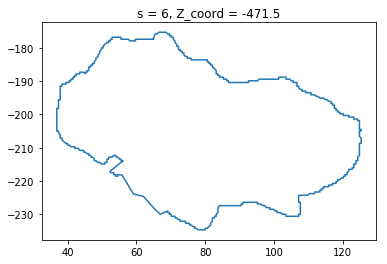

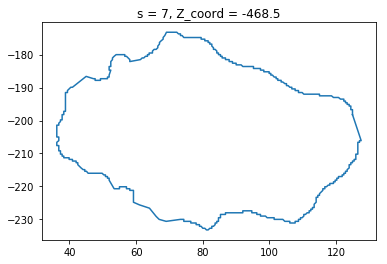

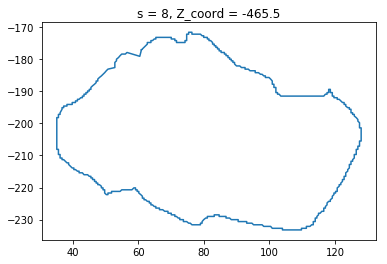

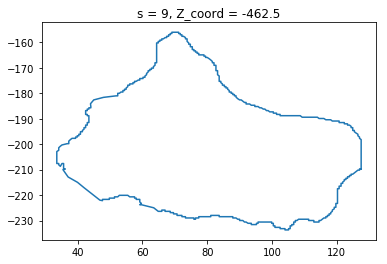

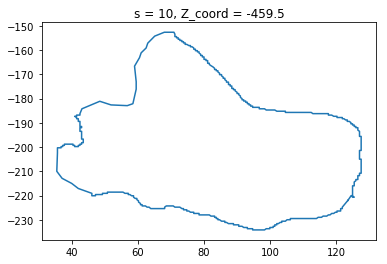

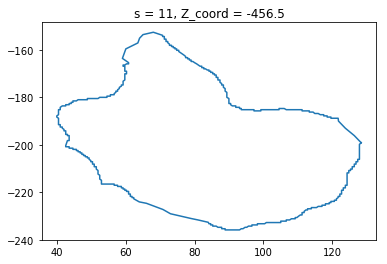

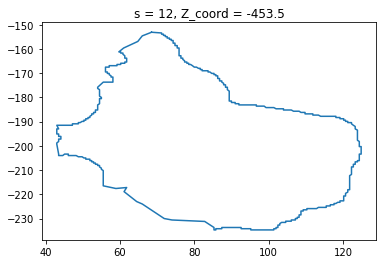

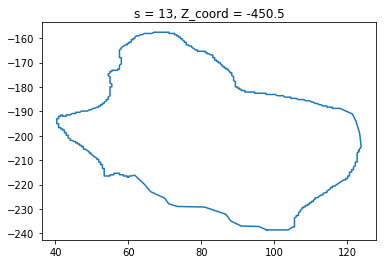

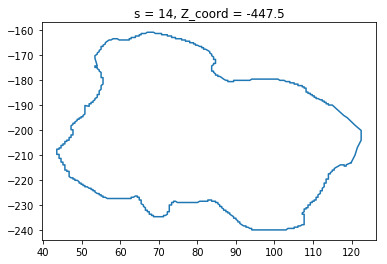

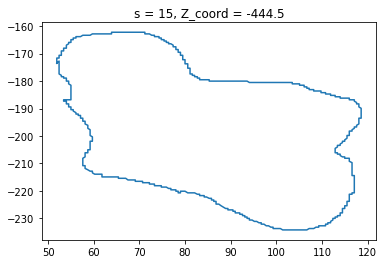

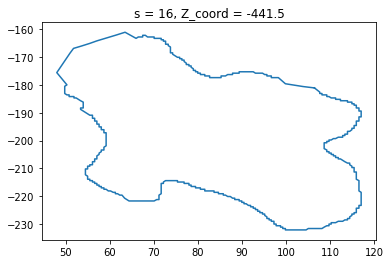

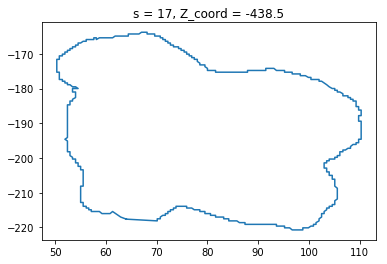

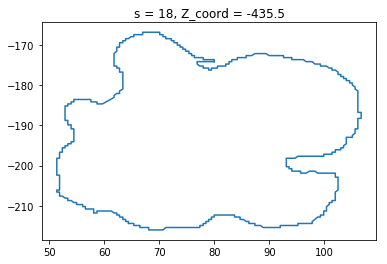

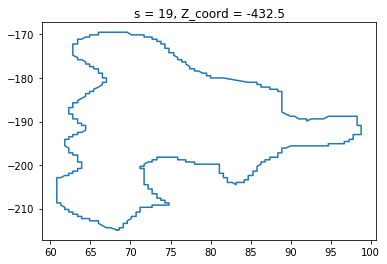

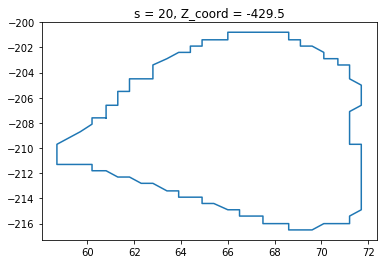

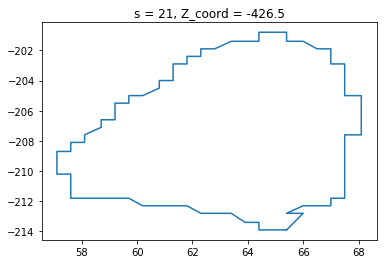

In [39]:
# visualization of ROI profiles on every slice

for i in range (len(n)):
    plt.figure(i)
    plt.plot(X[i], Y[i])
    plt.title('s = '+ str(i+1) + ', Z_coord = '+ str(Z[i][0]))
    plt.show()



In [40]:
X[0], Y[0], Z[0] # ROI on first slice

(array([78. , 78. , 77.3, 76.6, 75.9, 75.2, 74.5, 74.5, 73.8, 73.1, 73.1,
        72.4, 71.7, 71.7, 71. , 71. , 70.3, 70.3, 69.6, 69.6, 68.9, 68.9,
        68.9, 68.2, 68.2, 68.2, 67.5, 67.5, 67.5, 67.5, 67.5, 67.5, 68.2,
        68.9, 69.6, 70.3, 71. , 71.7, 72.4, 73.1, 73.1, 73.8, 74.5, 74.5,
        75.2, 75.2, 75.9, 75.9, 76.6, 76.6, 76.6, 76.6, 77.3, 77.3, 77.3,
        78. , 78. , 78. , 78. , 78. ]),
 array([-217.2, -217.9, -217.9, -217.9, -217.9, -217.9, -217.9, -217.2,
        -217.2, -217.2, -216.5, -216.5, -216.5, -215.8, -215.8, -215.1,
        -215.1, -214.4, -214.4, -213.7, -213.7, -213. , -212.3, -212.3,
        -211.5, -210.8, -210.8, -210.1, -209.4, -208.7, -208. , -207.3,
        -206.6, -206.6, -206.6, -206.6, -206.6, -206.6, -206.6, -206.6,
        -207.3, -207.3, -208. , -208.7, -208.7, -209.4, -209.4, -210.1,
        -210.1, -210.8, -211.5, -212.3, -212.3, -213. , -213.7, -214.4,
        -215.1, -215.8, -216.5, -217.2]),
 array([-486.5, -486.5, -486.5, -486.5, -486

In [41]:
dcm_img.SliceLocation # should be as Z coord of slice on DICOM image

"-300.5"

5. For LUNG 001

Acquiring the data for the 1st patient to further write a script for automated data acquisition across all the patients

"-486.5"

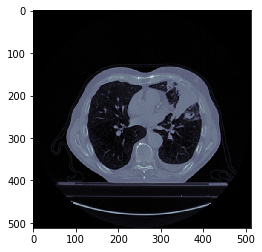

In [43]:
# 0th step
# first contour - 94th image
# checking estimated result

#should remove that paths below

path = '/Users/elizavetalavrova/Desktop/NSCLC-Radiomics/LUNG1-001/09-18-2008-StudyID-69331/0-82046/'
contour_filename = '/Users/elizavetalavrova/Desktop/NSCLC-Radiomics/LUNG1-001/09-18-2008-StudyID-69331/0-95085/000000.dcm'

image_filename = path + '000094.dcm'

#image_filename = """some"""path + '000094.dcm'

rt = pydicom.read_file(contour_filename)
img = pydicom.read_file(image_filename)

plt.imshow(img.pixel_array, cmap=plt.cm.bone)
img.SliceLocation

In [44]:
# STARTING PROCESSING FOR LUNG1-001

# reading RT data

contour_filename = db[db['PatientID']=='LUNG1-001']['loc'][0][0]
rt = pydicom.read_file(contour_filename)
N_contours = len(rt.ROIContourSequence[0].ContourSequence)

# SHOULD BE IN FOR LOOP

In [45]:
# reading coordinates of all the points of RT file

ctrs = rt.ROIContourSequence

X = []
Y = []
Z = []

n = np.array([])

for i in range (0, len(ctrs[0].ContourSequence)):
    x = np.array([])
    y = np.array([])
    z = np.array([])
    n = np.append(n, len(ctrs[0].ContourSequence[i].ContourData)/3)
    
    for j in range (0, int(len(ctrs[0].ContourSequence[i].ContourData)/3)):
        x = np.append(x, ctrs[0].ContourSequence[i].ContourData[3*j])
        y = np.append(y, ctrs[0].ContourSequence[i].ContourData[3*j+1])
        z = np.append(z, ctrs[0].ContourSequence[i].ContourData[3*j+2])
    X.append(x)
    Y.append(y)
    Z.append(z)
    
flat_X = [item for sublist in X for item in sublist]
flat_Y = [item for sublist in Y for item in sublist]
flat_Z = [item for sublist in Z for item in sublist]

#len(X), len(Y), len(Z), len(n)

#SHOULD BE IMPLEMENTED AS A FUNCTION

In [46]:
# tables of contour-imgfile correspondance with the use of UID

contour_UID = []
image_UID = []
image_filenames = []

for i in range (0, N_contours):
    contour_UID.append(rt.ROIContourSequence[0].ContourSequence[i].ContourImageSequence[0].ReferencedSOPInstanceUID)
    
for i in range (0, len(db[db['PatientID']=='LUNG1-001']['loi'][0])):
    I = {
        'name': '',
        'UID': ''
    }
    I['name'] = db[db['PatientID']=='LUNG1-001']['loi'][0][i]
    img = pydicom.read_file(I['name'])
    I['UID'] = img.SOPInstanceUID
    image_UID.append(I)
    
image_UID = pd.DataFrame(image_UID, columns=['name','UID'])

for i in range (0, N_contours):
    rec_UID = image_UID[image_UID['UID']==contour_UID[i]]
    image_filenames.append(rec_UID['name'].values[0])
    
# SHOULD BE IMPLEMENTED AS A FUNCTION

"-486.5"

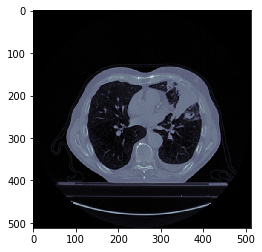

In [47]:
# (found imgfile for 0th contour)

img = pydicom.read_file(image_filenames[0])
plt.imshow(img.pixel_array, cmap=plt.cm.bone)
img.SliceLocation

In [48]:
# contour voxel coordinates based on imgfile attributes

# Image Orientation (Patient) (0020,0037) 
Xx = float(img.ImageOrientationPatient[0])
Xy = float(img.ImageOrientationPatient[1])
Xz = float(img.ImageOrientationPatient[2])

# Image Orientation (Patient) (0020,0037) 
Yx = float(img.ImageOrientationPatient[3])
Yy = float(img.ImageOrientationPatient[4])
Yz = float(img.ImageOrientationPatient[5])

# Image Position (Patient) (0020,0032)
Sx = float(img.ImagePositionPatient[0])
Sy = float(img.ImagePositionPatient[1])
Sz = float(img.ImagePositionPatient[2])

# Pixel Spacing (0028,0030)
delta_i = img.PixelSpacing[0]
delta_j = img.PixelSpacing[1]

xy = [] # array of voxel positions 

A = np.array([[Xx*delta_i, Yx*delta_j], [Xy*delta_i, Yy*delta_j]])
A_i = np.linalg.inv(A)

for i in range (0, len(X[0])):
    V = np.array([X[0][i]-Sx, Y[0][i]-Sy])
    xy_pair = np.dot(A_i, V)
    xy.append(xy_pair)
    
# array of integer contour voxel coordinates on slice

XY = np.array(xy)
XY = np.round(XY)
XY = XY.astype(int)

#SHOULD BE IMPLEMENTED AS A FUNCTION

In [57]:
polygon = XY.flatten().tolist()

In [49]:
# just to put it before plotting to visualize it in appropriate scale

def show_large(h, w, factor):
    figsize = w / float(factor), h / float(factor)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')

Contour surface area, sqr mm:  128.90625


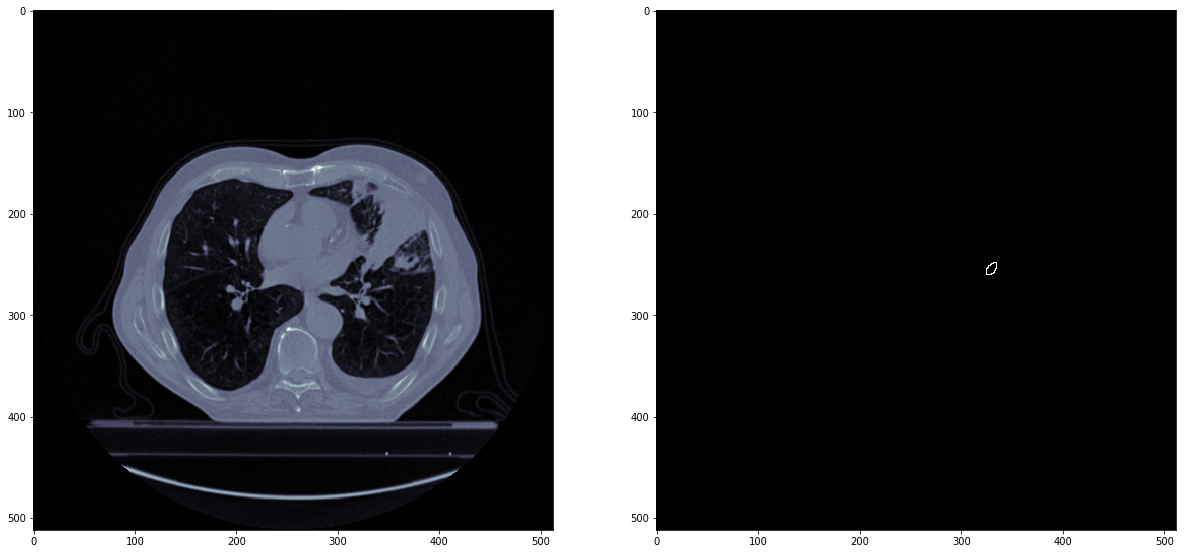

In [53]:
# slice mask contours + visualization

mask_cont = np.zeros((len(img.pixel_array), len(img.pixel_array)))

for i in range (0, len(XY)):
    mask_cont[XY[i,1], XY[i,0]] = 1
    
cont_surf_area = np.sum(mask_cont)*img.SliceThickness*np.mean(img.PixelSpacing) # might be useful for surface area calculation

height, width = mask_cont.shape

show_large(height, width, 25)

plt.subplot(121)
plt.imshow(img.pixel_array, cmap=plt.cm.bone)

plt.subplot(122)
plt.imshow(mask_cont, cmap = 'gray')

print('Contour surface area, sqr mm: ', cont_surf_area)
plt.show()


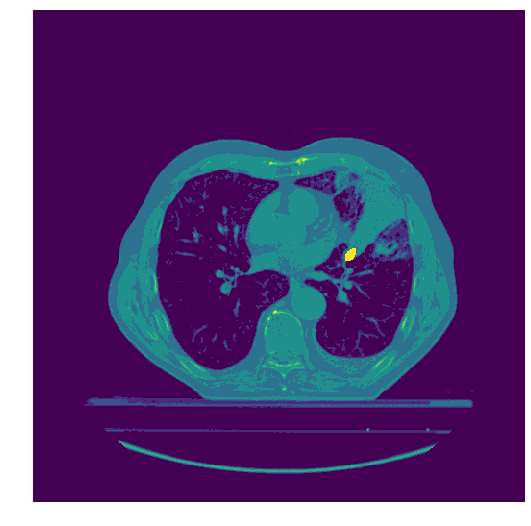

In [58]:
#plot contour on image

from PIL import Image, ImageDraw
import sys
from skimage import img_as_ubyte

img8 = img_as_ubyte(np.array(img.pixel_array))
Img8 = Image.fromarray(img8)

i_val = int(img8.max())

ImageDraw.Draw(Img8).polygon(polygon, outline=i_val, fill=i_val)
img_highlighted = np.array(Img8)

height, width = img_highlighted.shape
show_large(height, width, 75)

plt.imshow(img_highlighted)
plt.show()

# 2D MASK CREATION SHOULD BE IMPLEMENTED AS A FUNCTION

# HAVE TO CREATE 'FOR' LOOP FOR 'SLICE-GTV AREA' DATA

ROI area, sqr mm:  102.996826171875


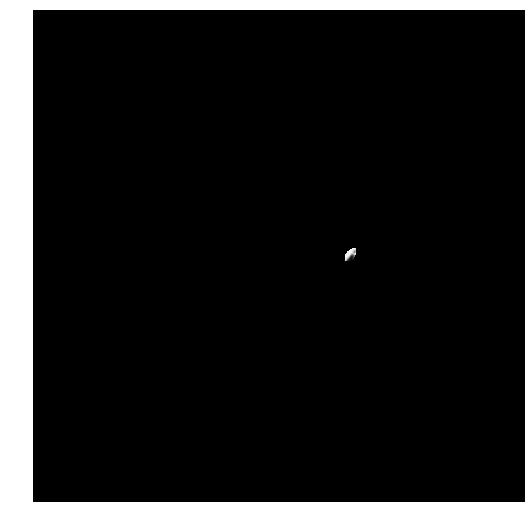

In [59]:
#plotting mask on image

from PIL import Image, ImageDraw
import sys
from skimage import img_as_ubyte

mask = np.zeros((len(img.pixel_array), len(img.pixel_array)))
Mask = Image.fromarray(mask)

ImageDraw.Draw(Mask).polygon(polygon, outline=1, fill=1)
mask = np.array(Mask)

contour_area = np.sum(mask)*img.PixelSpacing[0]*img.PixelSpacing[1]

img_masked = img.pixel_array*mask

height, width = mask.shape
show_large(height, width, 75)

print('ROI area, sqr mm: ', contour_area)
plt.imshow(img_masked, cmap = 'gray')
plt.show()

In [ ]:
# sorting the slices (actually names of image dcm files) in order of Z coordinate (incr/decr)

def slices_sort(list_of_images):
    dat = []
    for i in range (0, len(list_of_images)):
        dcm_img = dicom.read(list_of_images[i])

# ...
        
        
        

In [ ]:
# 3D image and 3D mask formation

DCARR = np.zeros((img.Rows, img.Columns, len(db[db['PatientID']=='LUNG1-001']['loi'][0])), dtype=img.pixel_array.dtype)

#...